# 1. Setup

### 1.1 Install libraries

In [1]:
# !pip install modAL

# import modAL
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download(['stopwords', 'punkt'])

###  1.2 Displaying results of GridSearch

In [2]:
''' source https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search '''

def GridSearch_table_plot(grid_clf, param_name, num_results=15, negative=True, display_all_params=True):
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

### 1.3 Efficiency measures

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

class Metrics:
    def __init__(self, test_set_y, predictions, method_name, classes):
        self.test_set_y = test_set_y
        self.predictions = predictions
        self.method_name = method_name
        self.classes = classes

    def accuracy(self):
        print('Accuracy Score : ', str(accuracy_score(self.test_set_y, self.predictions)))

    def mcc(self):
        print('MCC : ', str(matthews_corrcoef(self.test_set_y, self.predictions)))

    def confusion_matrix(self):
        cf_matrix_val_purpose = confusion_matrix(self.test_set_y, self.predictions)

        cmn = cf_matrix_val_purpose.astype('float') / cf_matrix_val_purpose.sum(axis=1)[:, np.newaxis]
        perc_labs = ["{0:.1%}".format(value) for value in cmn.flatten()]

        group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix_val_purpose.flatten()]

        print()
        box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,perc_labs)]
        box_labels = np.asarray(box_labels).reshape(cmn.shape[0],cmn.shape[1])

        fig, ax = plt.subplots(figsize=(6,6))
        sns.heatmap(cmn, annot=box_labels, fmt='', annot_kws={"fontsize":12},
                    xticklabels=list(self.classes), yticklabels=list(classes),
                    cmap='Blues', linecolor='lightgray', linewidths=0.5,
                    square=True, cbar=False, vmin=0, vmax=1)

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'plots/{self.method_name}.pdf')
        plt.show(block=False)
        plt.close()
        
    def all(self):
        print(self.method_name)
        self.accuracy()
        self.mcc()
        self.confusion_matrix()

# 2. Load data

## 2.1 Setup commons

In [4]:
datasets_path = '../datasets/'
gerrit_file = 'gerrit-wireshark-train-test-v4.xlsx'
eclipse_file = 'data_eclipse_openj9.csv'
eclipse_file_classified = 'data_eclipse_openj9_classified.csv'
indexes_file = 'indexes.csv'
indexes_stratified_file = 'indexes_stratified.csv'
indexes_stratified_classified_file = 'indexes_stratified_classified.csv'
seed = 41

import tensorflow as tf
tf.set_random_seed(seed)
import random
random.seed(seed)

## 2.2 Read dataset
Reads data from excel as a list of dicts with two keys: "message" and "purpose"

In [5]:
import pandas as pd


def read_excel(file_name, sheet_name):
    data = pd.read_excel(datasets_path + file_name, sheet_name=sheet_name, index_col=None, usecols=['message', 'purpose'])
    return data.to_dict(orient='record')

def read_csv(file_name):
    classification_data = pd.read_csv(datasets_path + file_name, encoding="ISO-8859-1", index_col=None)
    return classification_data.to_dict(orient='record')


def split_dataset_to_x_y(data_set):
    data_set_x = list([row['message'] for row in data_set])
    data_set_y = list([row['purpose'] for row in data_set])

    return data_set_x, data_set_y


data_set = read_csv(eclipse_file_classified)

## 2.3 [Optional] Map dataset classes

#### to 3 classes:

- definitely_worth_discussing -> change_request + discussion_trigger
- maybe_worth_discussing -> discussion_participation
- not_worth_discussing -> the rest

#### to 2 classes:
- worth_discussing -> change_request + discussion_trigger
- not_worth_discussing -> pozostale

In [6]:
# def map_classes(data_set, nr_of_classes):
#     if nr_of_classes == 3:
#         for i, element in enumerate(data_set):
#             if element['purpose'] == 'change_request' or element['purpose'] == 'discussion_trigger':
#                 data_set[i]['purpose'] = 'definitely_worth_discussing'
#             elif element['purpose'] == 'discussion_participation':
#                 data_set[i]['purpose'] = 'maybe_worth_discussing'
#             else:
#                 data_set[i]['purpose'] = 'not_worth_discussing'
#     elif nr_of_classes == 2:
#         for i, element in enumerate(data_set):
#             if element['purpose'] == 'change_request' or element['purpose'] == 'discussion_trigger':
#                 data_set[i]['purpose'] = 'worth_discussing'
#             else:
#                 data_set[i]['purpose'] = 'not_worth_discussing'

#     return data_set

# data_set = map_classes(data_set, 2)

## 2.4 [Optional] Generate indexes and save to file
The indexes.csv file has following structure: 
<br>[train_indexes]
<br>[test_indexes]

In [7]:
import csv
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


def generate_stratified_indexes(index, seed, data_set_x, data_set_y):
    sss = StratifiedShuffleSplit(n_splits=10, train_size = index, random_state=seed)
    for train_index, test_index in sss.split(data_set_x, data_set_y):
        return train_index, test_index

    
def generate_indexes(length, index, seed, data_set):
    random.seed(seed)
    np_array = np.arange(len(data_set))
    random.shuffle(np_array)
    split_index = int(index*len(data_set))
    return np_array[:split_index], np_array[split_index:]


data_set_x, data_set_y = split_dataset_to_x_y(data_set)
train_indexes, test_indexes = generate_stratified_indexes(0.9, seed, data_set_x, data_set_y)
# train_indexes, test_indexes = generate_indexes(len(data_set), 0.9, seed, data_set)
indexes = [train_indexes, test_indexes]

with open(indexes_stratified_classified_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(indexes)

## 2.5 Prepare training and testing set by
- splitting data according to previously generated to file indexes, or
- shuffling data and splitting its randomly

In [8]:
import csv

def read_indexes(indexes_file):
    with open(indexes_file, "r", newline="") as f:
        reader = csv.reader(f)
        train_indexes = next(reader)
        test_indexes = next(reader)
        return train_indexes, test_indexes


def split_set_with_indexes(data_set, train_indexes, test_indexes):
    train_set = [data_set[int(i)] for i in train_indexes]
    test_set = [data_set[int(i)] for i in test_indexes]
    return train_set, test_set


classes = set(element['purpose'] for element in data_set)
train_indexes, test_indexes = read_indexes(indexes_stratified_classified_file)    
train_set, test_set = split_set_with_indexes(data_set, train_indexes, test_indexes)

In [9]:
# def split_set_randomly(data_set, index, seed):
#     random.seed(seed)
#     random.shuffle(data_set)

#     split_index = int(index*len(data_set))
#     return data_set[:split_index], data_set[split_index:]

# train_set, test_set = split_set_randomly(data_set, 0.9, seed)

## 2.6 Split dataset to x and y

In [10]:
train_set_x, train_set_y = split_dataset_to_x_y(train_set)
test_set_x, test_set_y = split_dataset_to_x_y(test_set)

# 3. Experiment version A (BOW + classifiers)

## 3.1 Create BOW representation

In [11]:
import heapq

import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer


def tokenize(data_set):
    tokenizer = RegexpTokenizer("[a-zA-Z@]+")
    stemmer = SnowballStemmer("english")
    stop = stopwords.words('english')
    excluding = ['against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shouldn', "shouldn't", 'wasn',
                 "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
                'same', 'here', 'likewise', 'above', 'below']
    stop = [word for word in stop if word not in excluding]

    tokenized_data = []
    for message in data_set:
        message = tokenizer.tokenize(message)
        tokenized_data.append([stemmer.stem(w) for w in message if w not in stop])
    return tokenized_data


def join_tokens(data_set):
    joined = []
    for message in data_set:
        joined.append(" ".join([word for word in message]))
    return joined


def count_words_frequencies(data_set):
    frequencies = {}
    for message in data_set:
        words = nltk.word_tokenize(message)
        for word in words:
            if word not in frequencies.keys():
                frequencies[word] = 1
            else:
                frequencies[word] += 1
    return frequencies


def create_vector(messages, frequent_words):
    bow_model = []
    for message in messages:
        vector = []
        for word in frequent_words:
            if word in nltk.word_tokenize(message):
                vector.append(1)
            else:
                vector.append(0)
        bow_model.append(vector)
    return np.asarray(bow_model)


def create_bow_model(data_set_x, frequent_words_count):
    data_set_x = tokenize(data_set_x)
    data_set_x = join_tokens(data_set_x)
    
    word_frequencies = count_words_frequencies(data_set_x)
    frequent_words = heapq.nlargest(frequent_words_count, word_frequencies, key=word_frequencies.get)
    bow_model = create_vector(data_set_x, frequent_words)
    return bow_model


frequent_words_count = 100
train_bow_model = create_bow_model(train_set_x, frequent_words_count)
test_bow_model = create_bow_model(test_set_x, frequent_words_count)

## 3.2 Create classifiers

### 3.2.1 [Optional] Binary classifiers

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


class Classifier:
    def __init__(self, seed, train_bow_model, train_set_y, test_bow_model, test_set_y):
        self.seed = seed
        self.train_bow_model = train_bow_model
        self.train_set_y = train_set_y
        self.test_bow_model = test_bow_model
        self.test_set_y = test_set_y
    
    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=self.seed, 
                                     multi_class='ovr', 
                                     penalty='l2',
                                     max_iter=1000000, 
                                     class_weight='balanced', 
                                     solver='lbfgs', C=1)
        log_reg.fit(self.train_bow_model, self.train_set_y)
        return log_reg.predict(self.test_bow_model)
        
    def grid_search_logistic_regression(self):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                      'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']}
        grid_search = GridSearchCV(LogisticRegression(random_state=self.seed, max_iter=1000000,
                                                     class_weight='balanced'), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "C", negative=False)

    def random_forest(self, estimators_number):
        rfc = RandomForestClassifier(estimators_number, 
                                     random_state=self.seed,
                                     class_weight='balanced')
        rfc.fit(self.train_bow_model, self.train_set_y)
        return rfc.predict(self.test_bow_model)
        
    def grid_search_random_forest(self):
        param_grid = {'n_estimators': [1, 10, 100, 1000]}
        grid_search = GridSearchCV(RandomForestClassifier(random_state=self.seed), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "n_estimators", graph=False, negative=False)

    def decision_tree(self):
        decision_tree = DecisionTreeClassifier(random_state=self.seed, 
                                               splitter='random', 
                                               class_weight='balanced')
        decision_tree.fit(self.train_bow_model, self.train_set_y)
        return decision_tree.predict(self.test_bow_model)

### 3.2.2 Original 5 classes classifiers

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


class Classifier:
    def __init__(self, seed, train_bow_model, train_set_y, test_bow_model, test_set_y):
        self.seed = seed
        self.train_bow_model = train_bow_model
        self.train_set_y = train_set_y
        self.test_bow_model = test_bow_model
        self.test_set_y = test_set_y
    
    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=self.seed, multi_class='ovr', 
                                     penalty='elasticnet', l1_ratio=0.1, max_iter=1000000, 
                                     solver='saga', C=0.1)
        log_reg.fit(self.train_bow_model, self.train_set_y)
        return log_reg.predict(self.test_bow_model)
        
    def grid_search_logistic_regression(self):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                      'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']}
        grid_search = GridSearchCV(LogisticRegression(random_state=self.seed, max_iter=1000000), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "C", negative=False)

    def random_forest(self, estimators_number):
        rfc = RandomForestClassifier(estimators_number, 
                                     random_state=self.seed)
        rfc.fit(self.train_bow_model, self.train_set_y)
        return rfc.predict(self.test_bow_model)
        
    def grid_search_random_forest(self):
        param_grid = {'n_estimators': [1, 10, 100, 1000]}
        grid_search = GridSearchCV(RandomForestClassifier(random_state=self.seed), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "n_estimators", graph=False, negative=False)

    def decision_tree(self):
        decision_tree = DecisionTreeClassifier(random_state=self.seed,
                                              criterion='gini',
                                              splitter='random',
                                              class_weight='balanced')
        decision_tree.fit(self.train_bow_model, self.train_set_y)
        return decision_tree.predict(self.test_bow_model)

## 3.3 Run classifiers on BOW models

BOW_logistic_regression
Accuracy Score :  0.6534653465346535
MCC :  -0.06162867450335368



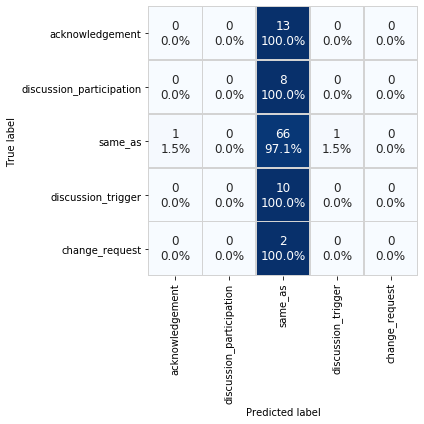

BOW_random_forest
Accuracy Score :  0.5643564356435643
MCC :  -0.08135971047714186



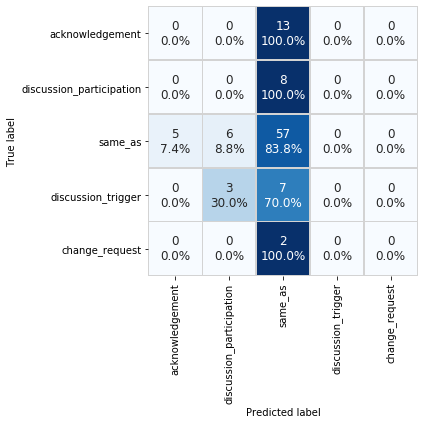

BOW_decision_tree
Accuracy Score :  0.37623762376237624
MCC :  -0.10932519715193915



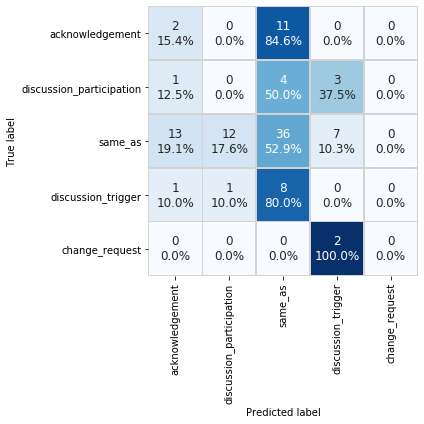

In [14]:
classifier = Classifier(seed, train_bow_model, train_set_y, test_bow_model, test_set_y)

predictions = classifier.logistic_regression()
metrics = Metrics(test_set_y, predictions, 'BOW_logistic_regression', classes)
metrics.all()

predictions = classifier.random_forest(100)
metrics = Metrics(test_set_y, predictions, 'BOW_random_forest', classes)
metrics.all()

predictions = classifier.decision_tree()
metrics = Metrics(test_set_y, predictions, 'BOW_decision_tree', classes)
metrics.all()

# 4. Experiment version B (mean vectors of WE + classifiers)

## 4.1 Load pre-trained StackOverflow WE model
Requires the 'SO_vectors_200.bin' file in current directory. Download here: https://zenodo.org/record/1199620#.XsRAw-GxW0k

In [15]:
from gensim.models.keyedvectors import KeyedVectors

word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

## 4.2 Tokenize comments

In [16]:
train_set_x_tokenized = tokenize(train_set_x)
test_set_x_tokenized = tokenize(test_set_x)

## 4.3 Convert comments to mean vectors
Each comment is converted to a vector which is a mean of all vectors of words in that comment. If a comment consists of words from outside the model, they are removed. If the whole comment is made of such words, the pair of (comment, purpose) is removed from x_set and y_set respectively.

In [17]:
import heapq
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec


def get_mean_vector(we_model, comment):
    words_in_we = [word for word in comment if word in we_model.vocab]
    if len(words_in_we) >= 1:
        return np.mean(we_model[words_in_we], axis=0)
    else:
        return []
    

def get_mean_vectors(data_set_x, data_set_y):
    indexes_to_remove = []
    data_set_vectors = []
    for index, comment in enumerate(data_set_x):
        vec = get_mean_vector(word_vect, comment)
        if len(vec) > 0:
            data_set_vectors.append(vec)
        else:
            indexes_to_remove.append(index)

    indexes_to_remove.sort(reverse=True)
    for index in indexes_to_remove:
        data_set_y.pop(index)
    return data_set_vectors

train_set_y_mean_vectors = train_set_y.copy()
train_set_x_mean_vectors = get_mean_vectors(train_set_x_tokenized, train_set_y_mean_vectors)
test_set_y_mean_vectors = test_set_y.copy()
test_set_x_mean_vectors = get_mean_vectors(test_set_x_tokenized, test_set_y_mean_vectors)

## 4.4 Run classifiers on mean vectors

WE_MV_logistic_regression
Accuracy Score :  0.8514851485148515
MCC :  0.6932989643192211



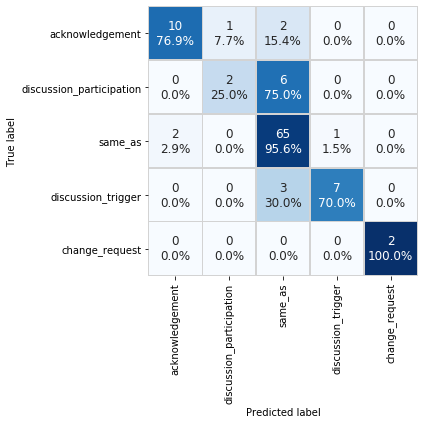

WE_MV_random_forest
Accuracy Score :  0.8811881188118812
MCC :  0.7582497507475021



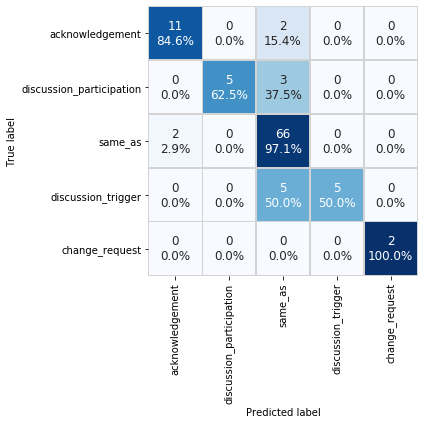

WE_MV_decision_tree
Accuracy Score :  0.7524752475247525
MCC :  0.5356871012336817



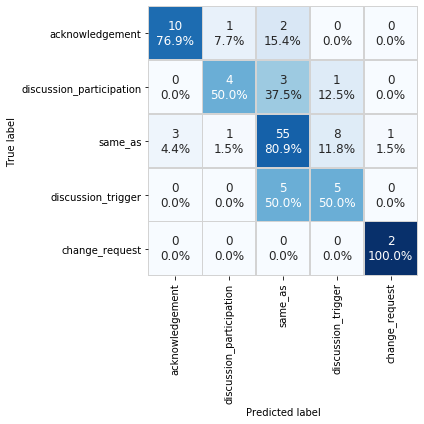

In [18]:
classifier = Classifier(seed, train_set_x_mean_vectors, train_set_y_mean_vectors, 
                        test_set_x_mean_vectors, test_set_y_mean_vectors)

predictions = classifier.logistic_regression()
metrics = Metrics(test_set_y_mean_vectors, predictions, 'WE_MV_logistic_regression', classes)
metrics.all()

predictions = classifier.random_forest(100)
metrics = Metrics(test_set_y_mean_vectors, predictions, 'WE_MV_random_forest', classes)
metrics.all()

predictions = classifier.decision_tree()
metrics = Metrics(test_set_y_mean_vectors, predictions, 'WE_MV_decision_tree', classes)
metrics.all()

# 5. Experiment version C (mean vectors of WE + Keras network)

## 5.1 Prepare data for Keras
- convert data_set_x to NumPy arrays
- convert data_set_y to one-hot encoded vectors

In [19]:
from sklearn import preprocessing 
from keras.utils import np_utils

def convert_to_numpy(data_set):
    return np.array(data_set)

def convert_class_to_number(encoder, Y):
    encoded_Y = encoder.fit_transform(Y)
    return encoded_Y

def convert_to_binary_vector(encoder, Y):
    encoded_Y = convert_class_to_number(encoder, Y)
    return np_utils.to_categorical(encoded_Y)

encoder = preprocessing.LabelEncoder()

train_set_x_numpy = convert_to_numpy(train_set_x_mean_vectors)
train_set_y_binary_vector = convert_to_binary_vector(encoder, train_set_y_mean_vectors)

test_set_x_numpy = convert_to_numpy(test_set_x_mean_vectors)
test_set_y_binary_vector = convert_to_binary_vector(encoder, test_set_y_mean_vectors)

classes = list(classes)
classes.sort()

# convert_to_numpy(train_set_x_mean_vectors, train_set_y_mean_vectors)
# test_set_x_numpy, test_set_y_numpy = convert_to_numpy(test_set_x_mean_vectors, test_set_y_mean_vectors)

Using TensorFlow backend.


## 5. 2 [Optional] Keras for binary classes

In [20]:
# from keras.models import Sequential
# from keras.layers import Dense, GRU
# from keras.layers import LSTM
# from keras.layers.embeddings import Embedding

# model = Sequential()
# model.add(Dense(200, activation='relu', input_dim=200))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X, Y, epochs=30, batch_size=64, verbose=1, validation_split=0.1)

# results = model.evaluate(X_test, Y_test, batch_size=64)
# print('loss, accuracy:', results)

# predictions = model.predict(X_test)
# predictions = [np.rint(prediction) for prediction in predictions]

# metrics = Metrics(Y_test, predictions, 'WE_MV_Keras_binary', classes)
# metrics.all()

## 5.3 Keras for 5 classes

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 00024: early stopping
101/101 [==============================] - 0s 37us/step
loss, accuracy: [0.3057266228859968, 0.8910890817642212]
WE_MV_Keras
Accuracy Score :  0.8910891089108911
MCC :  0.7859557197394744



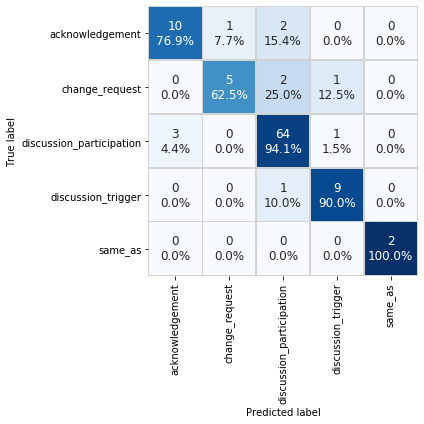

In [21]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(250, activation='relu', input_dim=200))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model.fit(train_set_x_numpy, train_set_y_binary_vector, epochs=100, 
          batch_size=64, verbose=0, validation_split=0.1, callbacks=[es])

results = model.evaluate(test_set_x_numpy, test_set_y_binary_vector, batch_size=64)
print('loss, accuracy:', results)

predictions = model.predict(test_set_x_numpy)

predictions_decoded = encoder.inverse_transform(np.argmax(predictions, axis=1))
test_set_y_decoded = encoder.inverse_transform(np.argmax(test_set_y_binary_vector, axis=1))

metrics = Metrics(test_set_y_decoded, predictions_decoded, 'WE_MV_Keras', classes)
metrics.all()

# 6. Experiment version D (self-trained Embeddings layer in Keras network)

## 6.1 Preprocessing
convert sentences to one_hot vectors, then pad to get equal lengths

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

all_words = set([item for sentence in train_set_x_tokenized + test_set_x_tokenized for item in sentence])
vocab_size = len(all_words)
longest_sentence = max(len(sentence) for sentence in train_set_x_tokenized)

def get_padded_sentences(data_set):
    sentences = join_tokens(data_set)
    encoded_sentences = [one_hot(sentence, vocab_size) for sentence in sentences]
    padded_sentences = pad_sequences(encoded_sentences, maxlen=longest_sentence, padding='post')
    return padded_sentences

train_set_x_padded = get_padded_sentences(train_set_x_tokenized)
test_set_x_padded = get_padded_sentences(test_set_x_tokenized)

train_set_y_binary_vector = convert_to_binary_vector(encoder, train_set_y)
test_set_y_binary_vector = convert_to_binary_vector(encoder, test_set_y)

In [23]:
print()

## 6.2 Run Keras with self-trained Embeddings

Epoch 00022: early stopping
101/101 [==============================] - 0s 51us/step
loss, accuracy: [0.5609200248623839, 0.8316831588745117]
WE_Keras_with_Own_Embeddings
Accuracy Score :  0.8316831683168316
MCC :  0.6528227747560535



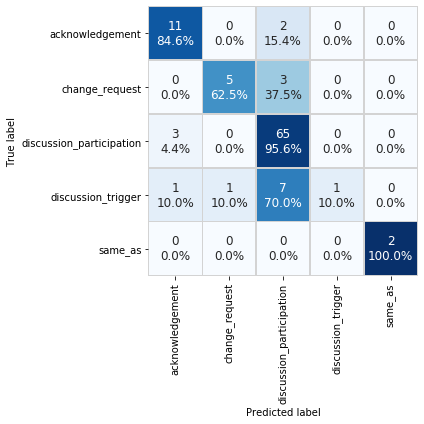

In [24]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Reshape, Dropout, Flatten
from keras.layers.embeddings import Embedding


longest_sentence = max(len(sentence) for sentence in train_set_x_tokenized)

model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=longest_sentence))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.fit(train_set_x_padded, train_set_y_binary_vector, 
          epochs=100, batch_size=64, verbose=0, validation_split=0.1, callbacks=[es])

results = model.evaluate(test_set_x_padded, test_set_y_binary_vector, batch_size=64)
print('loss, accuracy:', results)

predictions = model.predict(test_set_x_padded)

predictions_decoded = encoder.inverse_transform(np.argmax(predictions, axis=1))
test_set_y_decoded = encoder.inverse_transform(np.argmax(test_set_y_binary_vector, axis=1))

metrics = Metrics(test_set_y_decoded, predictions_decoded, 'WE_Keras_with_Own_Embeddings', classes)
metrics.all()

# 7. Experiment version E (StackOverflow Embeddings layer in Keras network) - work in progress

## 7.1 Preprocessing
convert each sentence to a vector of embeddings
all vectors are 121 elements long, each embedding is 200 elements long

In [25]:
# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import one_hot

# all_words = set([item for sentence in train_set_x_tokenized + test_set_x_tokenized for item in sentence])
# vocab_size = len(all_words)
# longest_sentence = max(len(sentence) for sentence in train_set_x_tokenized)

# def get_vectors_and_pad_sentences(data_set):
#     longest_examplary_vector = [np.zeros(200) for i in range(longest_sentence)]
#     vectors = []
#     for sentence in data_set:
#         vector = longest_examplary_vector.copy()
#         for index, word in enumerate(sentence):
#             if word in word_vect:
#                 vector[index] = word_vect[word]
#         vectors.append(vector)
#     return vectors

# train_set_x_padded = np.array(get_vectors_and_pad_sentences(train_set_x_tokenized))
# test_set_x_padded = np.array(get_vectors_and_pad_sentences(test_set_x_tokenized))

# train_set_y_binary_vector = convert_to_binary_vector(encoder, train_set_y)
# test_set_y_binary_vector = convert_to_binary_vector(encoder, test_set_y)

## 7.2 Run Keras with word embeddings as input

In [26]:
# from keras.models import Sequential
# from keras.layers import Dense, GRU, Reshape, Dropout, Flatten
# from keras.layers.embeddings import Embedding

# longest_sentence = max(len(sentence) for sentence in train_set_x_tokenized)

# model = Sequential()
# model.add(Dense(200, activation='relu', input_shape=(121,200)))
# # model.add(Dropout(0.2))
# model.add(Dense(5, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# print(model.summary())

# model.fit(train_set_x_padded, train_set_y_binary_vector, 
#           epochs=100, batch_size=64, verbose=0, validation_split=0.1)

# results = model.evaluate(test_set_x_padded, test_set_y_binary_vector, batch_size=64)
# print('loss, accuracy:', results)

# predictions = model.predict(test_set_x_padded)

# predictions_decoded = encoder.inverse_transform(np.argmax(predictions, axis=1))
# test_set_y_decoded = encoder.inverse_transform(np.argmax(test_set_y_binary_vector, axis=1))

# metrics = Metrics(test_set_y_decoded, predictions_decoded, 'WE_Keras_with_Embeddings', classes)
# metrics.all()

# 8. Experiment version E (GloVe Embeddings layer in Keras network) - work in progress
requires GloVe embeddings (path: CRClassifier/glove.6B/..)

## 8.1 Load GloVe dictionary
convert sentences to one_hot vectors, then pad to get equal lengths

In [27]:
# # load the whole embedding into memory
# embeddings_index = dict()
# f = open('glove.6B/glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [28]:
# embedding_matrix = zeros((vocab_size, 100))
#     for word, i in t.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# 9 Experiment wersion F (StackOverflow WE + 1D CNN) - work in progress

In [29]:
# from keras.models import Sequential
# from keras.layers import Dense, GRU, Conv1D, Dropout, MaxPooling1D, Flatten
# from keras.layers import LSTM
# from keras.layers.embeddings import Embedding

# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 200)))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X, Y, epochs=30, batch_size=64, verbose=0, validation_split=0.1)

# results = model.evaluate(X_test, Y_test, batch_size=64)
# print('loss, accuracy:', results)

# predictions = model.predict(X_test)
# # predictions = [np.rint(prediction) for prediction in predictions]

# predictions_decoded = encoder.inverse_transform(np.argmax(predictions, axis=1))
# Y_test_decoded = encoder.inverse_transform(np.argmax(Y_test, axis=1))

# metrics = Metrics(Y_test_decoded, predictions_decoded, 'WE_LSTM', classes)
# metrics.all()


# 	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# 	model = Sequential()
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# 	model.add(Dropout(0.5))
# 	model.add(MaxPooling1D(pool_size=2))
# 	model.add(Flatten())
# 	model.add(Dense(100, activation='relu'))
# 	model.add(Dense(n_outputs, activation='softmax'))
# 	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=